In [1]:
import os
import sys
import re
from matplotlib import pyplot as plt
from coffea.util import load
from omegaconf import OmegaConf
import numpy as np
import awkward as ak
from pocket_coffea.utils.plot_utils import PlotManager
import argparse
import mplhep as hep

hep.style.use("CMS")


In [2]:
var_name_dict={
                'u_perp_resolution': r'$\sigma u_{\perp}$ [GeV]',
            'u_perp_scaled_resolution': r'$\sigma u_{\perp} scaled$ [GeV]',
            'u_par_resolution': r'$\sigma u_{\parallel}$ [GeV]',
            'u_par_scaled_resolution': r'$\sigma u_{\parallel} scaled$ [GeV]',
            'R': r'-$<u_{||}>/<q_{T}>$',
}

In [3]:
def create_histos(qT_arr, resolutions_arr):
    # compute mean of all metrics in summary
    max_x=200 # max qT value
    x_n=20 #number of bins

    bin_edges=np.arange(0, max_x, 10)
    inds=np.digitize(qT_arr,bin_edges)
    print(inds[inds>7])
    qT_hist=[]
    for i in range(1, len(bin_edges)):
        qT_hist.append((bin_edges[i]+bin_edges[i-1])/2.)
    
    resolution_hists={}
    for key in resolutions_arr:
        print(key)
        R_arr=resolutions_arr[key][2] 
        u_perp_arr=resolutions_arr[key][0]
        u_par_arr=resolutions_arr[key][1]
        
        print(R_arr, len(R_arr))
        print(u_perp_arr, len(u_perp_arr))
        print(u_par_arr, len(u_par_arr))

        u_perp_hist=[] 
        u_perp_scaled_hist=[]
        u_par_hist=[]
        u_par_scaled_hist=[]
        R_hist=[]

        for i in range(1, len(bin_edges)):
            R_i=R_arr[np.where(inds==i)[0]]
            R_hist.append(np.mean(R_i))
            u_perp_i=u_perp_arr[np.where(inds==i)[0]]
            u_perp_scaled_i=u_perp_i/np.mean(R_i)
            u_perp_hist.append((np.quantile(u_perp_i,0.84)-np.quantile(u_perp_i,0.16))/2.)
            u_perp_scaled_hist.append((np.quantile(u_perp_scaled_i,0.84)-np.quantile(u_perp_scaled_i,0.16))/2.)
            u_par_i=u_par_arr[np.where(inds==i)[0]]
            u_par_scaled_i=u_par_i/np.mean(R_i)
            u_par_hist.append((np.quantile(u_par_i,0.84)-np.quantile(u_par_i,0.16))/2.)
            u_par_scaled_hist.append((np.quantile(u_par_scaled_i,0.84)-np.quantile(u_par_scaled_i,0.16))/2.)

        u_perp_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_perp_hist)
        u_perp_scaled_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_perp_scaled_hist)
        u_par_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_par_hist)
        u_par_scaled_resolution=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=u_par_scaled_hist)
        R=np.histogram(qT_hist, bins=x_n, range=(0,max_x), weights=R_hist)
        resolution_hists[key] = {
            'u_perp_resolution': u_perp_resolution,
            'u_perp_scaled_resolution': u_perp_scaled_resolution,
            'u_par_resolution': u_par_resolution,
            'u_par_scaled_resolution':u_par_scaled_resolution,
            'R': R
        }
    return resolution_hists

In [4]:
def plot_histos(histo_dict):
    for var_name in ['u_perp_resolution', 'u_perp_scaled_resolution', 'u_par_resolution', 'u_par_scaled_resolution', 'R']:
        fig, ax = plt.subplots()
        for key in histo_dict:
            ax.errorbar(histo_dict[key][var_name][1][:-1], histo_dict[key][var_name][0], label=key, fmt=".",)
        ax.legend()
        ax.set_xlabel(r'Z q$_{\mathrm{T}}$ [GeV]')
        ax.set_ylabel(var_name if var_name not in var_name_dict else var_name_dict[var_name])
        hep.cms.lumitext(r"(13.6 TeV)", ax=ax)
        hep.cms.text(text="Simulation Preliminary", ax=ax)
        # fig.savefig(f'{var_name}.png')
        # plt.close(fig)
        fig.show()

In [5]:
input_dir = "/work/mmalucch/out_MET/out_DY_rerun_fixes/"
# input_dir = "/pnfs/psi.ch/cms/trivcat/store/user/mmalucch/out_jme/DY_MET_NoStandardJEC"
inputfile = os.path.join(input_dir, "output_all.coffea")
outputdir = os.path.join(input_dir, "plots_comparison")
accumulator = load(inputfile)
sample = list(accumulator["columns"].keys())[0]
dataset = list(accumulator["columns"][sample].keys())[0]
category = list(accumulator["columns"][sample][dataset].keys())[0]

col_dict={}
for var in accumulator["columns"][sample][dataset][category]:
    col_dict[var]=accumulator["columns"][sample][dataset][category][var].value

v_qT=col_dict["ll_pt"]

resolutions_arr={}

for var in col_dict:
    if "_MuonGood" in var and any(x in var for x in ["u_perp_predict", "u_paral_predict", "response"]):
        coll=var.split("_")[0]
        if coll not in resolutions_arr:
            resolutions_arr[coll]=[]
        print(var)
        resolutions_arr[coll].append(col_dict[var])





PuppiMET_MuonGood_u_perp_predict
PuppiMET_MuonGood_u_paral_predict
PuppiMET_MuonGood_response
PuppiMETPNet_MuonGood_u_perp_predict
PuppiMETPNet_MuonGood_u_paral_predict
PuppiMETPNet_MuonGood_response
PuppiMETPNetPlusNeutrino_MuonGood_u_perp_predict
PuppiMETPNetPlusNeutrino_MuonGood_u_paral_predict
PuppiMETPNetPlusNeutrino_MuonGood_response


[ 8  9 16 ... 11  8  8]
PuppiMET
[-0.39294278  1.01846328 -0.26405005 ...  0.55505435  1.94337845
  1.42044821] 3101309
[83.41422321 -2.23855363 10.95847886 ... 17.90990817  5.58288687
  7.23847397] 3101309
[-13.03918479   0.10643857  -4.94338282 ...  -4.26602826   2.35865237
   5.66358593] 3101309
PuppiMETPNet
[-0.16919044  1.1670562  -0.96174172 ...  0.6231982   2.37503446
  1.71985672] 3101309
[84.07208082 -8.6929009   9.43789953 ... 18.18535184  5.37146151
  6.13064552] 3101309
[-17.84523583   0.9630585   -0.25698124 ...  -3.61268194   3.43788677
   9.69672424] 3101309
PuppiMETPNetPlusNeutrino
[-0.15514324  1.18191335 -0.94438221 ...  0.63306801  2.30500436
  1.90879862] 3101309
[84.29580248 -8.70255196  9.61288766 ... 18.18373214  5.37709993
  6.47375064] 3101309
[-18.14696034   1.04870812  -0.37358524 ...  -3.51805266   3.26279623
  12.2418384 ] 3101309


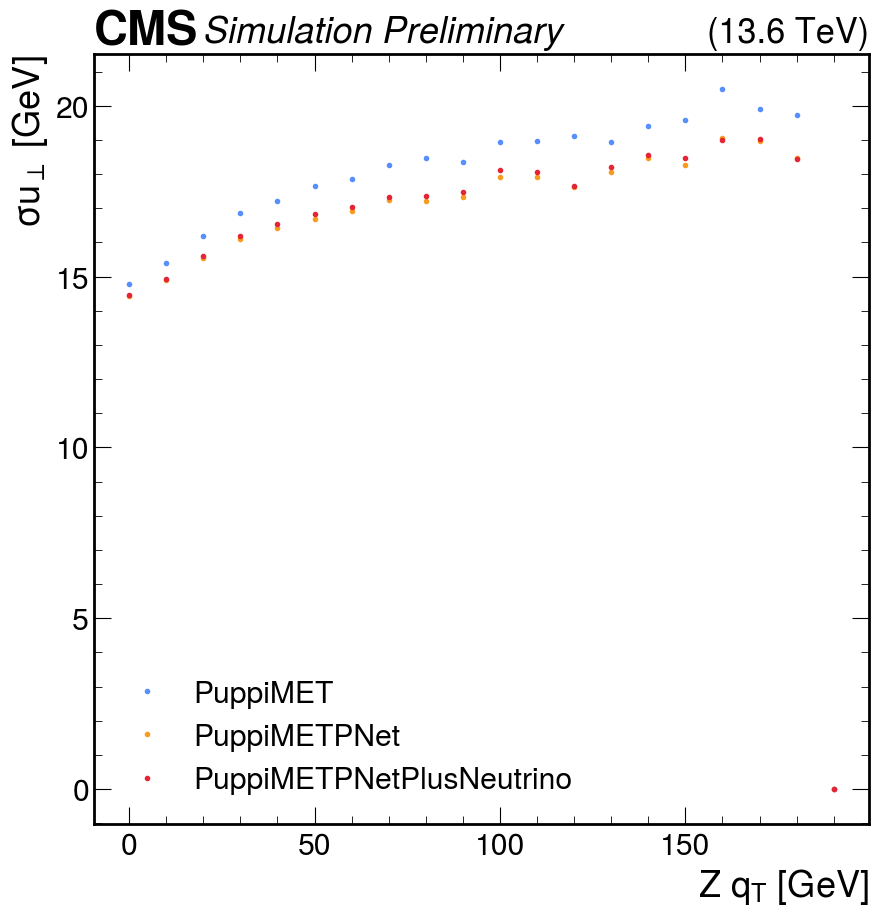

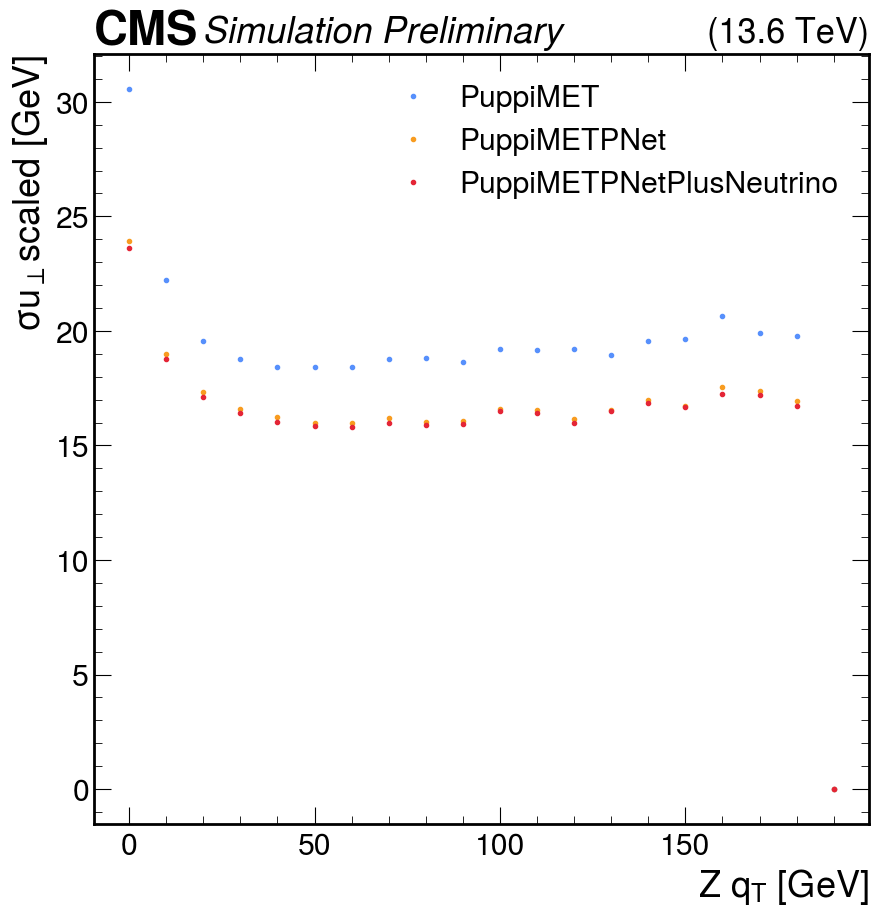

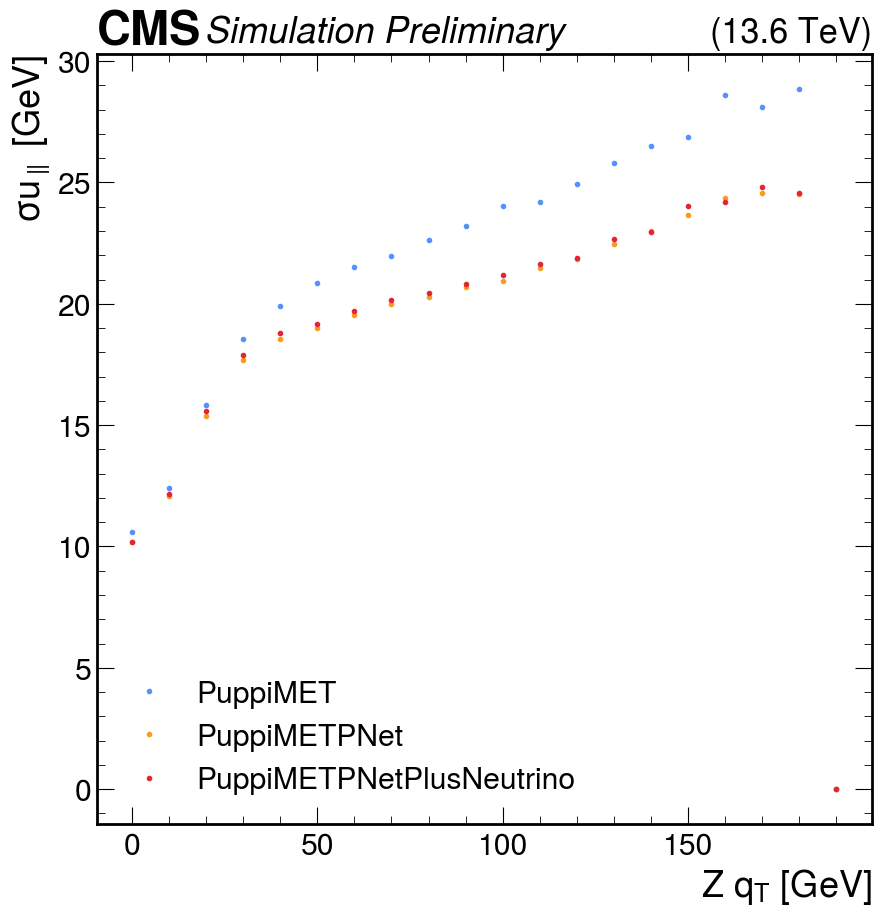

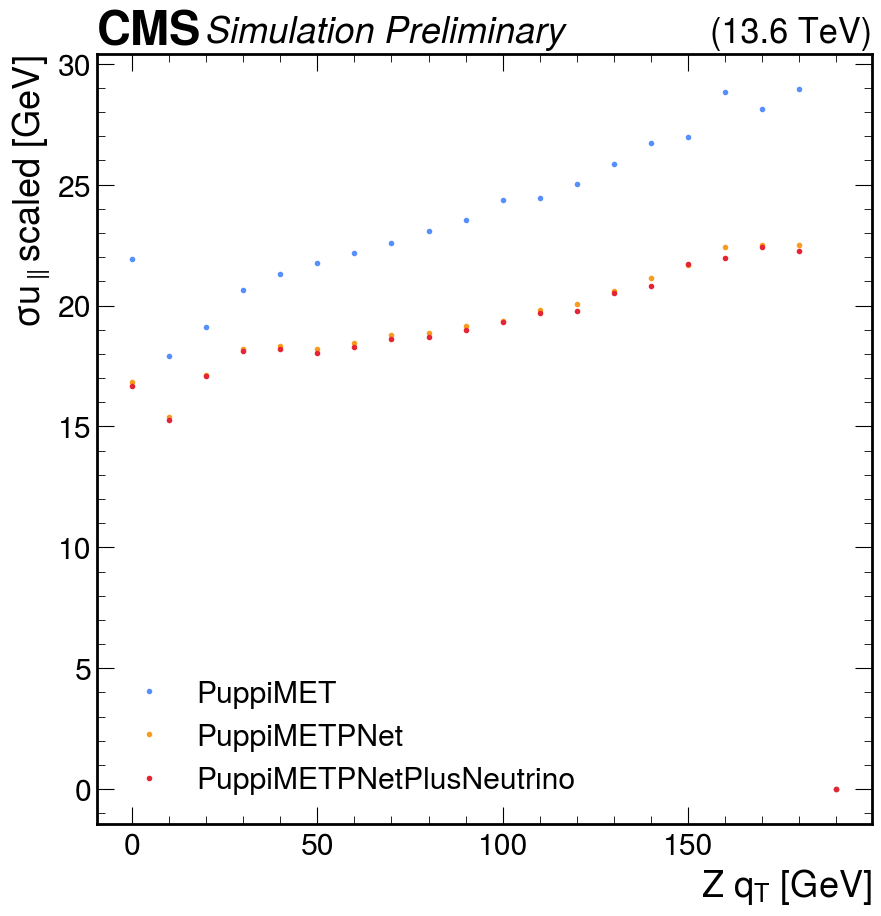

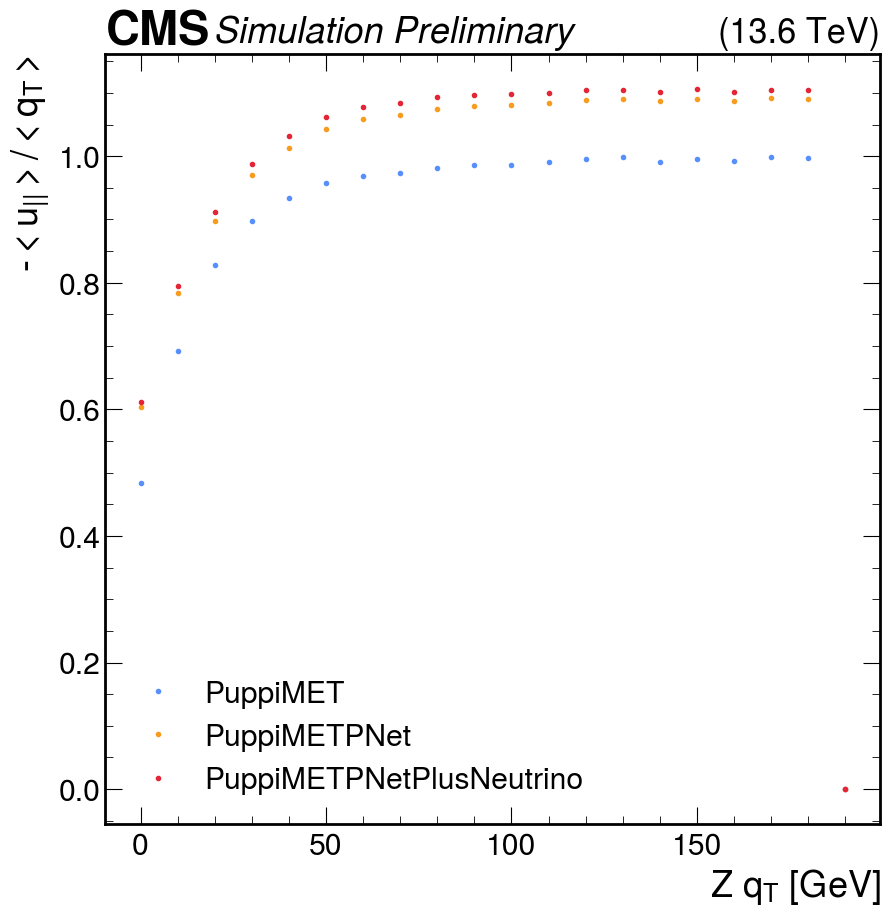

In [6]:
resolution_hists=create_histos(v_qT, resolutions_arr)
plot_histos(resolution_hists)

In [8]:
print(resolutions_arr)

{'PuppiMET': [array([83.41422321, -2.23855363, 10.95847886, ..., 17.90990817,
        5.58288687,  7.23847397]), array([-13.03918479,   0.10643857,  -4.94338282, ...,  -4.26602826,
         2.35865237,   5.66358593]), array([-0.39294278,  1.01846328, -0.26405005, ...,  0.55505435,
        1.94337845,  1.42044821])], 'PuppiMETPNet': [array([84.07208082, -8.6929009 ,  9.43789953, ..., 18.18535184,
        5.37146151,  6.13064552]), array([-17.84523583,   0.9630585 ,  -0.25698124, ...,  -3.61268194,
         3.43788677,   9.69672424]), array([-0.16919044,  1.1670562 , -0.96174172, ...,  0.6231982 ,
        2.37503446,  1.71985672])], 'PuppiMETPNetPlusNeutrino': [array([84.29580248, -8.70255196,  9.61288766, ..., 18.18373214,
        5.37709993,  6.47375064]), array([-18.14696034,   1.04870812,  -0.37358524, ...,  -3.51805266,
         3.26279623,  12.2418384 ]), array([-0.15514324,  1.18191335, -0.94438221, ...,  0.63306801,
        2.30500436,  1.90879862])]}
